In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7fe913b1bd30>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


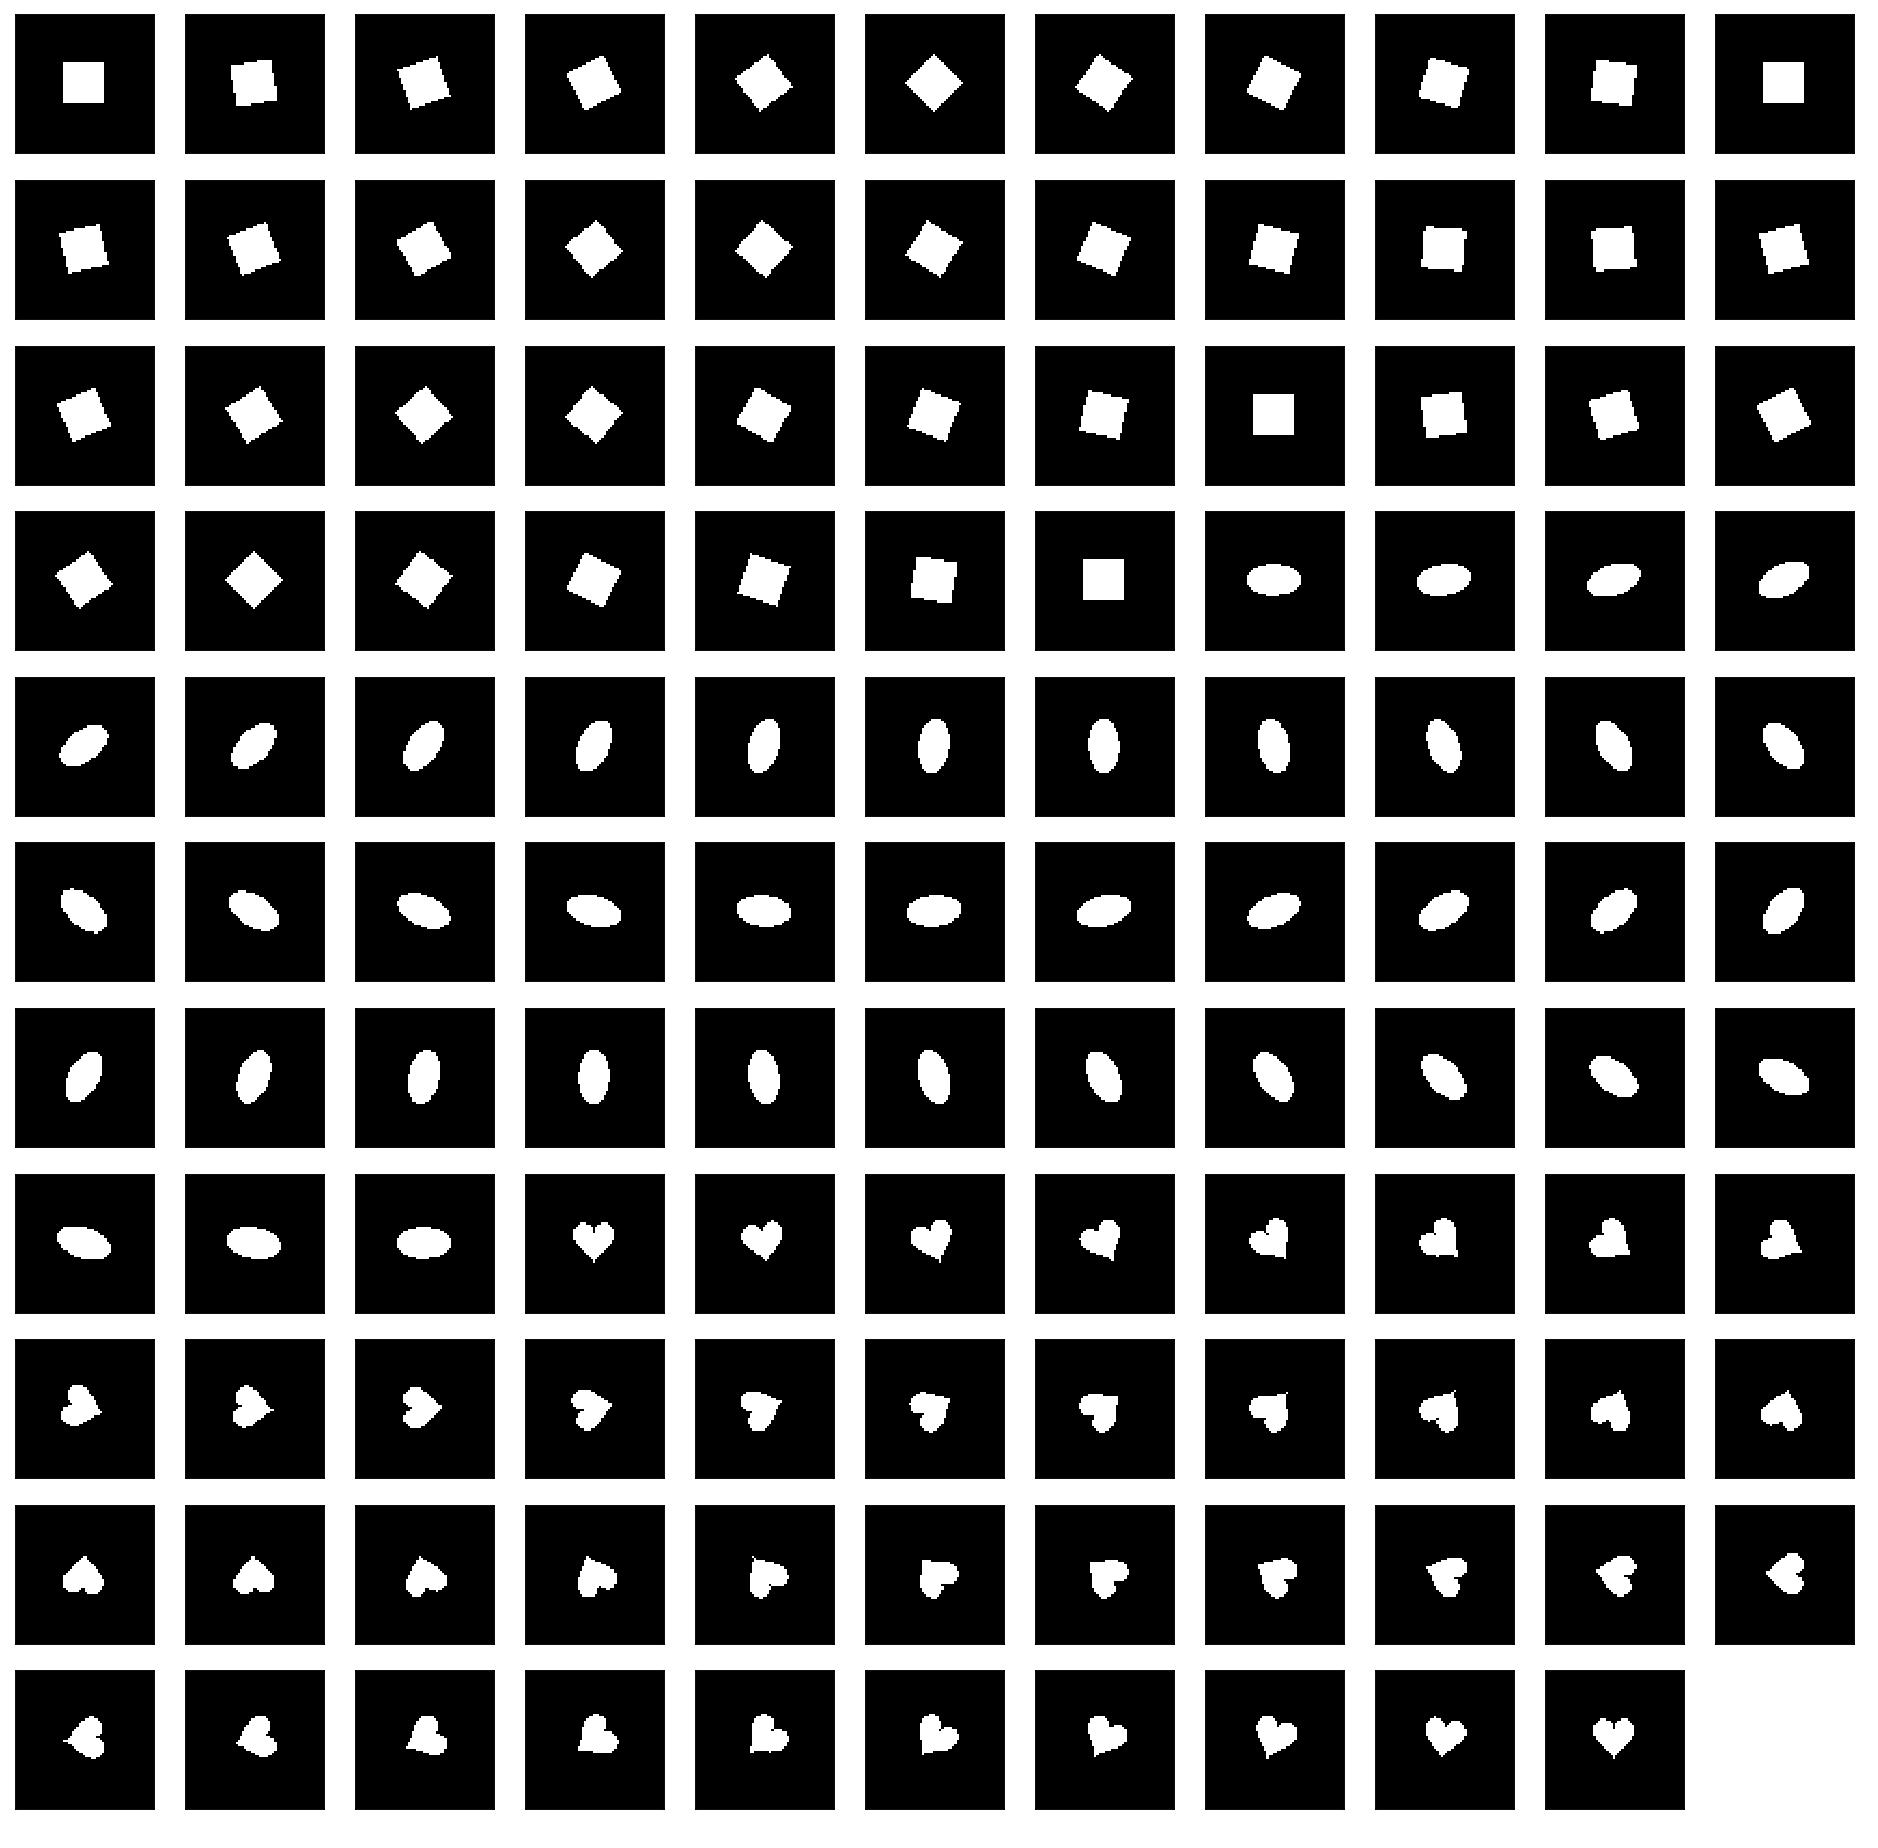

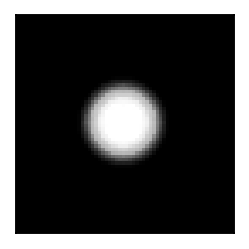

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

96


In [4]:
ff.shape[0]*0.8
idx_test

array([  0,   1,   6,  14,  15,  20,  22,  23,  24,  28,  32,  43,  46,
        51,  55,  67,  85,  92,  93,  96, 104, 105, 110, 118])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [6]:
x_train.shape

(96, 4096)

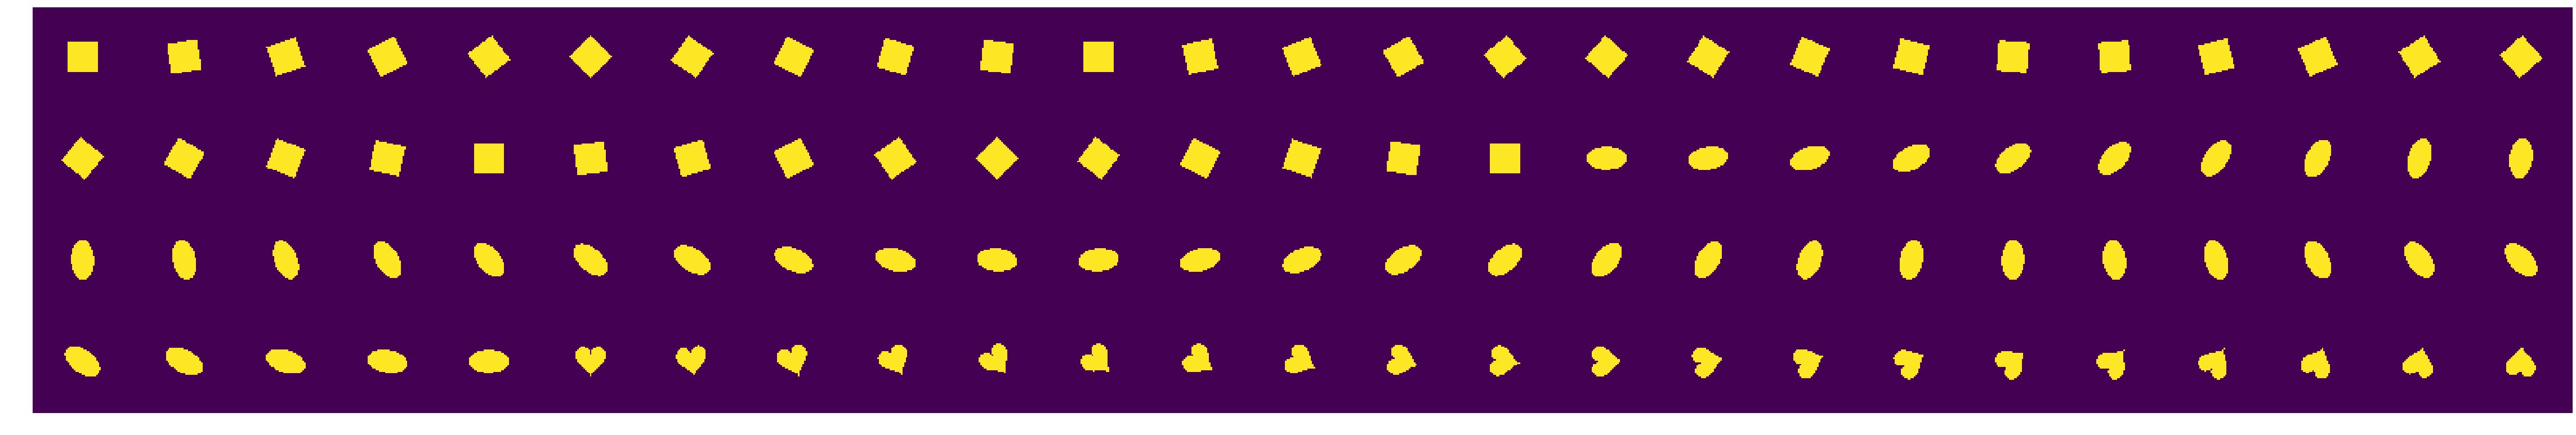

In [7]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [8]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [9]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [10]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_x = np.linspace(-2, 2, n)
    
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [11]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 20
latent_dim = 3
epochs = 100

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [13]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [14]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [15]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [16]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,728
Trainable params: 2,249,728
Non-trainable params: 0
_________________________________________________________________


In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [18]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 2245830   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249728   
Total params: 4,495,558
Trainable params: 4,495,558
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = int(1E3)

In [20]:
from keras.callbacks import ModelCheckpoint

'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
#model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None), 
        callbacks=[checkpointer])

Train on 96 samples, validate on 24 samples
Epoch 1/1000
96/96 [==============================] - 1s 11ms/step - loss: 2686.1944 - val_loss: 1825.6948

Epoch 00001: val_loss improved from inf to 1825.69478, saving model to weights.hdf5
Epoch 2/1000
96/96 [==============================] - 0s 532us/step - loss: 1134.4837 - val_loss: 413.8739

Epoch 00002: val_loss improved from 1825.69478 to 413.87394, saving model to weights.hdf5
Epoch 3/1000
96/96 [==============================] - 0s 582us/step - loss: 328.0602 - val_loss: 294.8328

Epoch 00003: val_loss improved from 413.87394 to 294.83282, saving model to weights.hdf5
Epoch 4/1000
96/96 [==============================] - 0s 507us/step - loss: 262.5441 - val_loss: 265.1851

Epoch 00004: val_loss improved from 294.83282 to 265.18515, saving model to weights.hdf5
Epoch 5/1000
96/96 [==============================] - 0s 480us/step - loss: 244.8803 - val_loss: 252.6741

Epoch 00005: val_loss improved from 265.18515 to 252.67405, saving 

96/96 [==============================] - 0s 610us/step - loss: 100.9497 - val_loss: 181.0987

Epoch 00095: val_loss did not improve from 148.49255
Epoch 96/1000
96/96 [==============================] - 0s 631us/step - loss: 92.9241 - val_loss: 175.8358

Epoch 00096: val_loss did not improve from 148.49255
Epoch 97/1000
96/96 [==============================] - 0s 615us/step - loss: 94.6278 - val_loss: 162.7617

Epoch 00097: val_loss did not improve from 148.49255
Epoch 98/1000
96/96 [==============================] - 0s 657us/step - loss: 95.6146 - val_loss: 173.7194

Epoch 00098: val_loss did not improve from 148.49255
Epoch 99/1000
96/96 [==============================] - 0s 615us/step - loss: 94.3244 - val_loss: 164.7033

Epoch 00099: val_loss did not improve from 148.49255
Epoch 100/1000
96/96 [==============================] - 0s 635us/step - loss: 85.5145 - val_loss: 164.9605

Epoch 00100: val_loss did not improve from 148.49255
Epoch 101/1000
96/96 [==============================


Epoch 00145: val_loss did not improve from 143.02985
Epoch 146/1000
96/96 [==============================] - 0s 619us/step - loss: 79.3201 - val_loss: 158.1461

Epoch 00146: val_loss did not improve from 143.02985
Epoch 147/1000
96/96 [==============================] - 0s 628us/step - loss: 84.3541 - val_loss: 168.9736

Epoch 00147: val_loss did not improve from 143.02985
Epoch 148/1000
96/96 [==============================] - 0s 631us/step - loss: 79.6067 - val_loss: 167.3096

Epoch 00148: val_loss did not improve from 143.02985
Epoch 149/1000
96/96 [==============================] - 0s 635us/step - loss: 79.0426 - val_loss: 178.6101

Epoch 00149: val_loss did not improve from 143.02985
Epoch 150/1000
96/96 [==============================] - 0s 626us/step - loss: 74.5755 - val_loss: 163.9495

Epoch 00150: val_loss did not improve from 143.02985
Epoch 151/1000
96/96 [==============================] - 0s 617us/step - loss: 72.9592 - val_loss: 162.9502

Epoch 00151: val_loss did not imp


Epoch 00196: val_loss did not improve from 143.02985
Epoch 197/1000
96/96 [==============================] - 0s 601us/step - loss: 64.7976 - val_loss: 169.6975

Epoch 00197: val_loss did not improve from 143.02985
Epoch 198/1000
96/96 [==============================] - 0s 625us/step - loss: 69.0616 - val_loss: 158.1995

Epoch 00198: val_loss did not improve from 143.02985
Epoch 199/1000
96/96 [==============================] - 0s 689us/step - loss: 62.1678 - val_loss: 169.3780

Epoch 00199: val_loss did not improve from 143.02985
Epoch 200/1000
96/96 [==============================] - 0s 580us/step - loss: 66.4284 - val_loss: 147.3550

Epoch 00200: val_loss did not improve from 143.02985
Epoch 201/1000
96/96 [==============================] - 0s 624us/step - loss: 69.1051 - val_loss: 167.1759

Epoch 00201: val_loss did not improve from 143.02985
Epoch 202/1000
96/96 [==============================] - 0s 629us/step - loss: 68.2812 - val_loss: 132.9267

Epoch 00202: val_loss improved fr

96/96 [==============================] - 0s 639us/step - loss: 50.7831 - val_loss: 172.7406

Epoch 00298: val_loss did not improve from 132.92675
Epoch 299/1000
96/96 [==============================] - 0s 624us/step - loss: 53.3735 - val_loss: 146.1104

Epoch 00299: val_loss did not improve from 132.92675
Epoch 300/1000
96/96 [==============================] - 0s 624us/step - loss: 55.7112 - val_loss: 161.7711

Epoch 00300: val_loss did not improve from 132.92675
Epoch 301/1000
96/96 [==============================] - 0s 630us/step - loss: 49.2482 - val_loss: 141.8808

Epoch 00301: val_loss did not improve from 132.92675
Epoch 302/1000
96/96 [==============================] - 0s 640us/step - loss: 64.6880 - val_loss: 152.5097

Epoch 00302: val_loss did not improve from 132.92675
Epoch 303/1000
96/96 [==============================] - 0s 618us/step - loss: 94.7294 - val_loss: 158.6598

Epoch 00303: val_loss did not improve from 132.92675
Epoch 304/1000
96/96 [===========================

96/96 [==============================] - 0s 631us/step - loss: 52.8671 - val_loss: 157.4337

Epoch 00349: val_loss did not improve from 132.92675
Epoch 350/1000
96/96 [==============================] - 0s 631us/step - loss: 48.4902 - val_loss: 152.8826

Epoch 00350: val_loss did not improve from 132.92675
Epoch 351/1000
96/96 [==============================] - 0s 618us/step - loss: 50.9832 - val_loss: 160.5031

Epoch 00351: val_loss did not improve from 132.92675
Epoch 352/1000
96/96 [==============================] - 0s 616us/step - loss: 42.5366 - val_loss: 161.2096

Epoch 00352: val_loss did not improve from 132.92675
Epoch 353/1000
96/96 [==============================] - 0s 643us/step - loss: 49.8243 - val_loss: 163.3355

Epoch 00353: val_loss did not improve from 132.92675
Epoch 354/1000
96/96 [==============================] - 0s 622us/step - loss: 64.0114 - val_loss: 161.6276

Epoch 00354: val_loss did not improve from 132.92675
Epoch 355/1000
96/96 [===========================

96/96 [==============================] - 0s 618us/step - loss: 53.0243 - val_loss: 169.9224

Epoch 00400: val_loss did not improve from 132.92675
Epoch 401/1000
96/96 [==============================] - 0s 615us/step - loss: 51.6162 - val_loss: 178.8691

Epoch 00401: val_loss did not improve from 132.92675
Epoch 402/1000
96/96 [==============================] - 0s 627us/step - loss: 52.6158 - val_loss: 173.4466

Epoch 00402: val_loss did not improve from 132.92675
Epoch 403/1000
96/96 [==============================] - 0s 620us/step - loss: 41.5721 - val_loss: 167.8775

Epoch 00403: val_loss did not improve from 132.92675
Epoch 404/1000
96/96 [==============================] - 0s 625us/step - loss: 46.2988 - val_loss: 159.1517

Epoch 00404: val_loss did not improve from 132.92675
Epoch 405/1000
96/96 [==============================] - 0s 629us/step - loss: 45.6794 - val_loss: 153.7901

Epoch 00405: val_loss did not improve from 132.92675
Epoch 406/1000
96/96 [===========================

96/96 [==============================] - 0s 632us/step - loss: 47.3239 - val_loss: 178.8522

Epoch 00451: val_loss did not improve from 132.92675
Epoch 452/1000
96/96 [==============================] - 0s 618us/step - loss: 58.1173 - val_loss: 164.9356

Epoch 00452: val_loss did not improve from 132.92675
Epoch 453/1000
96/96 [==============================] - 0s 626us/step - loss: 54.6245 - val_loss: 158.3432

Epoch 00453: val_loss did not improve from 132.92675
Epoch 454/1000
96/96 [==============================] - 0s 647us/step - loss: 61.4614 - val_loss: 197.2897

Epoch 00454: val_loss did not improve from 132.92675
Epoch 455/1000
96/96 [==============================] - 0s 627us/step - loss: 46.9946 - val_loss: 185.2405

Epoch 00455: val_loss did not improve from 132.92675
Epoch 456/1000
96/96 [==============================] - 0s 613us/step - loss: 42.9391 - val_loss: 173.2411

Epoch 00456: val_loss did not improve from 132.92675
Epoch 457/1000
96/96 [===========================

96/96 [==============================] - 0s 622us/step - loss: 38.8831 - val_loss: 171.7381

Epoch 00502: val_loss did not improve from 132.92675
Epoch 503/1000
96/96 [==============================] - 0s 629us/step - loss: 41.8760 - val_loss: 174.5739

Epoch 00503: val_loss did not improve from 132.92675
Epoch 504/1000
96/96 [==============================] - 0s 629us/step - loss: 46.6524 - val_loss: 185.2073

Epoch 00504: val_loss did not improve from 132.92675
Epoch 505/1000
96/96 [==============================] - 0s 624us/step - loss: 42.5213 - val_loss: 177.3979

Epoch 00505: val_loss did not improve from 132.92675
Epoch 506/1000
96/96 [==============================] - 0s 626us/step - loss: 40.6276 - val_loss: 177.9826

Epoch 00506: val_loss did not improve from 132.92675
Epoch 507/1000
96/96 [==============================] - 0s 637us/step - loss: 41.9212 - val_loss: 168.6542

Epoch 00507: val_loss did not improve from 132.92675
Epoch 508/1000
96/96 [===========================

96/96 [==============================] - 0s 627us/step - loss: 39.5794 - val_loss: 182.6268

Epoch 00553: val_loss did not improve from 132.92675
Epoch 554/1000
96/96 [==============================] - 0s 627us/step - loss: 41.8075 - val_loss: 182.8613

Epoch 00554: val_loss did not improve from 132.92675
Epoch 555/1000
96/96 [==============================] - 0s 628us/step - loss: 44.9262 - val_loss: 166.4367

Epoch 00555: val_loss did not improve from 132.92675
Epoch 556/1000
96/96 [==============================] - 0s 623us/step - loss: 41.0149 - val_loss: 177.1949

Epoch 00556: val_loss did not improve from 132.92675
Epoch 557/1000
96/96 [==============================] - 0s 624us/step - loss: 40.4481 - val_loss: 183.3868

Epoch 00557: val_loss did not improve from 132.92675
Epoch 558/1000
96/96 [==============================] - 0s 618us/step - loss: 45.8454 - val_loss: 174.3191

Epoch 00558: val_loss did not improve from 132.92675
Epoch 559/1000
96/96 [===========================

96/96 [==============================] - 0s 606us/step - loss: 39.2659 - val_loss: 210.6837

Epoch 00604: val_loss did not improve from 132.92675
Epoch 605/1000
96/96 [==============================] - 0s 620us/step - loss: 43.6488 - val_loss: 207.1516

Epoch 00605: val_loss did not improve from 132.92675
Epoch 606/1000
96/96 [==============================] - 0s 632us/step - loss: 38.7171 - val_loss: 203.2018

Epoch 00606: val_loss did not improve from 132.92675
Epoch 607/1000
96/96 [==============================] - 0s 639us/step - loss: 47.2210 - val_loss: 201.6555

Epoch 00607: val_loss did not improve from 132.92675
Epoch 608/1000
96/96 [==============================] - 0s 629us/step - loss: 41.9153 - val_loss: 203.2503

Epoch 00608: val_loss did not improve from 132.92675
Epoch 609/1000
96/96 [==============================] - 0s 619us/step - loss: 34.9517 - val_loss: 191.2862

Epoch 00609: val_loss did not improve from 132.92675
Epoch 610/1000
96/96 [===========================

96/96 [==============================] - 0s 615us/step - loss: 44.5490 - val_loss: 191.1454

Epoch 00655: val_loss did not improve from 132.92675
Epoch 656/1000
96/96 [==============================] - 0s 625us/step - loss: 45.0369 - val_loss: 190.7459

Epoch 00656: val_loss did not improve from 132.92675
Epoch 657/1000
96/96 [==============================] - 0s 633us/step - loss: 41.1163 - val_loss: 186.1536

Epoch 00657: val_loss did not improve from 132.92675
Epoch 658/1000
96/96 [==============================] - 0s 625us/step - loss: 47.1402 - val_loss: 197.6987

Epoch 00658: val_loss did not improve from 132.92675
Epoch 659/1000
96/96 [==============================] - 0s 624us/step - loss: 47.4877 - val_loss: 188.0831

Epoch 00659: val_loss did not improve from 132.92675
Epoch 660/1000
96/96 [==============================] - 0s 625us/step - loss: 41.9021 - val_loss: 213.8183

Epoch 00660: val_loss did not improve from 132.92675
Epoch 661/1000
96/96 [===========================

96/96 [==============================] - 0s 636us/step - loss: 39.4081 - val_loss: 189.8864

Epoch 00706: val_loss did not improve from 132.92675
Epoch 707/1000
96/96 [==============================] - 0s 620us/step - loss: 53.5755 - val_loss: 181.7772

Epoch 00707: val_loss did not improve from 132.92675
Epoch 708/1000
96/96 [==============================] - 0s 625us/step - loss: 39.7327 - val_loss: 212.7752

Epoch 00708: val_loss did not improve from 132.92675
Epoch 709/1000
96/96 [==============================] - 0s 656us/step - loss: 41.6084 - val_loss: 205.7997

Epoch 00709: val_loss did not improve from 132.92675
Epoch 710/1000
96/96 [==============================] - 0s 632us/step - loss: 51.2098 - val_loss: 185.1794

Epoch 00710: val_loss did not improve from 132.92675
Epoch 711/1000
96/96 [==============================] - 0s 622us/step - loss: 41.0300 - val_loss: 198.3839

Epoch 00711: val_loss did not improve from 132.92675
Epoch 712/1000
96/96 [===========================

96/96 [==============================] - 0s 625us/step - loss: 43.0463 - val_loss: 178.4633

Epoch 00757: val_loss did not improve from 132.92675
Epoch 758/1000
96/96 [==============================] - 0s 623us/step - loss: 38.7633 - val_loss: 200.5033

Epoch 00758: val_loss did not improve from 132.92675
Epoch 759/1000
96/96 [==============================] - 0s 629us/step - loss: 46.0624 - val_loss: 189.8361

Epoch 00759: val_loss did not improve from 132.92675
Epoch 760/1000
96/96 [==============================] - 0s 640us/step - loss: 41.8883 - val_loss: 201.5064

Epoch 00760: val_loss did not improve from 132.92675
Epoch 761/1000
96/96 [==============================] - 0s 626us/step - loss: 39.8856 - val_loss: 213.4151

Epoch 00761: val_loss did not improve from 132.92675
Epoch 762/1000
96/96 [==============================] - 0s 648us/step - loss: 40.2814 - val_loss: 219.2701

Epoch 00762: val_loss did not improve from 132.92675
Epoch 763/1000
96/96 [===========================

96/96 [==============================] - 0s 628us/step - loss: 43.2406 - val_loss: 211.6586

Epoch 00808: val_loss did not improve from 132.92675
Epoch 809/1000
96/96 [==============================] - 0s 621us/step - loss: 48.9878 - val_loss: 222.1256

Epoch 00809: val_loss did not improve from 132.92675
Epoch 810/1000
96/96 [==============================] - 0s 623us/step - loss: 43.2906 - val_loss: 207.8587

Epoch 00810: val_loss did not improve from 132.92675
Epoch 811/1000
96/96 [==============================] - 0s 624us/step - loss: 34.9570 - val_loss: 220.1507

Epoch 00811: val_loss did not improve from 132.92675
Epoch 812/1000
96/96 [==============================] - 0s 635us/step - loss: 42.6029 - val_loss: 213.8104

Epoch 00812: val_loss did not improve from 132.92675
Epoch 813/1000
96/96 [==============================] - 0s 631us/step - loss: 33.1370 - val_loss: 213.9255

Epoch 00813: val_loss did not improve from 132.92675
Epoch 814/1000
96/96 [===========================

96/96 [==============================] - 0s 648us/step - loss: 46.1218 - val_loss: 215.0852

Epoch 00859: val_loss did not improve from 132.92675
Epoch 860/1000
96/96 [==============================] - 0s 631us/step - loss: 52.9715 - val_loss: 235.2433

Epoch 00860: val_loss did not improve from 132.92675
Epoch 861/1000
96/96 [==============================] - 0s 622us/step - loss: 37.6348 - val_loss: 212.9415

Epoch 00861: val_loss did not improve from 132.92675
Epoch 862/1000
96/96 [==============================] - 0s 628us/step - loss: 35.9974 - val_loss: 229.9758

Epoch 00862: val_loss did not improve from 132.92675
Epoch 863/1000
96/96 [==============================] - 0s 634us/step - loss: 48.4753 - val_loss: 282.2614

Epoch 00863: val_loss did not improve from 132.92675
Epoch 864/1000
96/96 [==============================] - 0s 630us/step - loss: 43.7744 - val_loss: 253.7795

Epoch 00864: val_loss did not improve from 132.92675
Epoch 865/1000
96/96 [===========================

96/96 [==============================] - 0s 586us/step - loss: 31.7724 - val_loss: 203.0051

Epoch 00910: val_loss did not improve from 132.92675
Epoch 911/1000
96/96 [==============================] - 0s 622us/step - loss: 36.3644 - val_loss: 192.9616

Epoch 00911: val_loss did not improve from 132.92675
Epoch 912/1000
96/96 [==============================] - 0s 632us/step - loss: 32.3315 - val_loss: 211.4452

Epoch 00912: val_loss did not improve from 132.92675
Epoch 913/1000
96/96 [==============================] - 0s 627us/step - loss: 35.2105 - val_loss: 214.6767

Epoch 00913: val_loss did not improve from 132.92675
Epoch 914/1000
96/96 [==============================] - 0s 640us/step - loss: 64.4245 - val_loss: 211.5584

Epoch 00914: val_loss did not improve from 132.92675
Epoch 915/1000
96/96 [==============================] - 0s 628us/step - loss: 29.6356 - val_loss: 247.0730

Epoch 00915: val_loss did not improve from 132.92675
Epoch 916/1000
96/96 [===========================

96/96 [==============================] - 0s 614us/step - loss: 39.5596 - val_loss: 199.7929

Epoch 00961: val_loss did not improve from 132.92675
Epoch 962/1000
96/96 [==============================] - 0s 637us/step - loss: 43.9438 - val_loss: 189.9886

Epoch 00962: val_loss did not improve from 132.92675
Epoch 963/1000
96/96 [==============================] - 0s 631us/step - loss: 35.0661 - val_loss: 197.8250

Epoch 00963: val_loss did not improve from 132.92675
Epoch 964/1000
96/96 [==============================] - 0s 640us/step - loss: 34.9129 - val_loss: 195.7858

Epoch 00964: val_loss did not improve from 132.92675
Epoch 965/1000
96/96 [==============================] - 0s 627us/step - loss: 38.0052 - val_loss: 210.1721

Epoch 00965: val_loss did not improve from 132.92675
Epoch 966/1000
96/96 [==============================] - 0s 615us/step - loss: 34.6689 - val_loss: 223.4246

Epoch 00966: val_loss did not improve from 132.92675
Epoch 967/1000
96/96 [===========================

In [21]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input: 0':x_train})

In [22]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([ 0.17869286, -0.08096359,  0.04486062], dtype=float32)

In [23]:
np.cov(z_output.T)

array([[ 1.01052645e+00, -2.98681525e-09,  7.20108540e-09],
       [-2.98681525e-09,  1.01052618e+00, -1.08011360e-08],
       [ 7.20108540e-09, -1.08011360e-08,  1.01052639e+00]])

Plot the Pearson correlation among Z

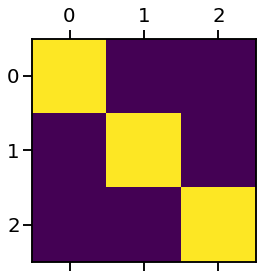

In [24]:
plt.matshow(np.corrcoef(z_output.T))

In [25]:
z_m_m

array([ 0.17869286, -0.08096359,  0.04486062], dtype=float32)

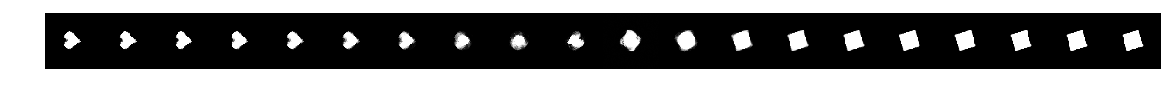

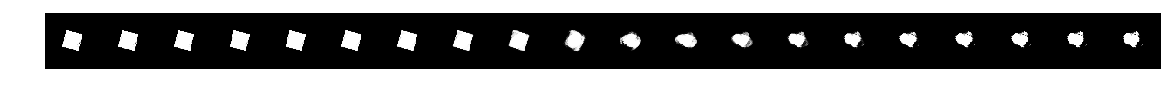

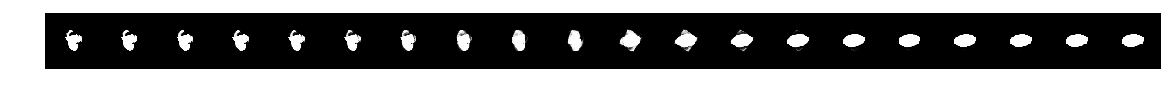

In [26]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")